In [35]:
import pandas as pd
import matplotlib.pyplot as pyplt
%pylab inline
from IPython.display import display
pd.options.display.max_columns = None

from sklearn.linear_model import Ridge, LinearRegression, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

from azureml import Workspace

ws = Workspace()
ds = ws.datasets['county_facts_dictionary.csv']
frame = ds.to_dataframe()

trainDF = ws.datasets['ames_train.csv'].to_dataframe();
testDF = ws.datasets['ames_test.csv'].to_dataframe();
sampleSubmissionDF = ws.datasets['ames_sample_submission.csv'].to_dataframe();

all_data = pd.concat((trainDF.loc[:,'MSSubClass':'SaleCondition'],
                      testDF.loc[:,'MSSubClass':'SaleCondition']))
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

Populating the interactive namespace from numpy and matplotlib


/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [36]:
X_train = all_data[:trainDF.shape[0]] #We are using raw selector operator
X_test = all_data[trainDF.shape[0]:]
y = trainDF.SalePrice

i = [1 for j in range(X_train.shape[0])]
i = np.array(i)
i = np.expand_dims(i, axis=1)
X_train = np.hstack((i, X_train.as_matrix()))
subset = X_train[:, 1:]
X_train_normalized = (subset - subset.min(0)) / subset.ptp(0)
#X_train_normalized = np.hstack((i, X_train_normalized)) We should not add intercep term before pca

i = [1 for j in range(X_test.shape[0])]
i = np.array(i)
i = np.expand_dims(i, axis=1)
X_test = np.hstack((i, X_test.as_matrix()))
subset = X_test[:, 1:]
X_test_normalized = (subset - subset.min(0)) / subset.ptp(0)
#X_test_normalized = np.hstack((i, X_test_normalized))

y = log(y).as_matrix()

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/kernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


In [37]:
def log_rmse_error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def direct_rmse_error(actual, predicted):
    ans = np.sqrt(np.sum(np.square(actual-predicted))/len(actual))
    return ans

def get_accuracy_lstsq_ridge(Xtr, Xte, Ytr, Yte, alpha):
    theta, residual, rank, singular = linalg.lstsq(Xtr, Ytr)
    Ypred = (Xte).dot(theta)
    return direct_rmse_error(Yte, Ypred)

def get_accuracy_matrix_ridge(Xtr, Xte, Ytr, Yte, alpha):
    I = np.identity(Xtr.shape[1])
    temp0 = Xtr.T.dot(Xtr) + alpha*I
    temp1 = linalg.inv(temp0)
    parameter = temp1.dot(Xtr.T).dot(Ytr)
    Ypred = Xte.dot(parameter)
    return direct_rmse_error(Yte, Ypred)

def my_cv_matrix(xin, yin, n_splits,alpha):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_train)
    ary = []
    for train_index, test_index in kf.split(xin):       
        Xtr, Xte = xin[train_index], xin[test_index]
        Ytr, Yte = yin[train_index], yin[test_index]
        ans = get_accuracy_matrix_ridge(Xtr, Xte, Ytr, Yte, alpha)
        ary.append(ans)
    return np.mean(ary)

def my_cv_lstsq(xin, yin, n_splits,alpha):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_train)
    ary = []
    for train_index, test_index in kf.split(xin):       
        Xtr, Xte = xin[train_index], xin[test_index]
        Ytr, Yte = yin[train_index], yin[test_index]
        ary.append(get_accuracy_lstsq(Xtr, Xte, Ytr, Yte, alpha))
    return np.mean(ary)

Ridge Regression With with lstsq.  
Not possible as lstaq requires equation of the form AX=B

Ridge Regression With Matrix

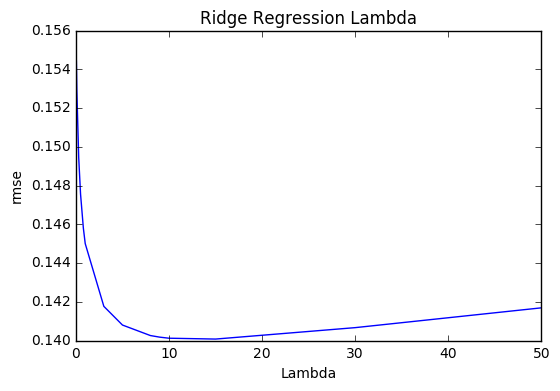

In [38]:
alphas = [0.05, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 8, 9, 10, 15, 30, 50]
cv_ridge = []
cv_ridge = [my_cv_matrix(X_train, y, 5, alpha) 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Regression Lambda")
plt.xlabel("Lambda")
plt.ylabel("rmse")

As exptected both are simialr, as there is unique solution

## Result in Error as determinant is zero

In [39]:
a = X_train.T.dot(X_train)

In [40]:
linalg.det(a)

-1399073.7491626097

In [41]:
# b = linalg.inv(a)

## SVD

We need to genrate sigma matrix.

In [42]:
X_train_normalized.shape

(1460, 288)

In [43]:
sigma = X_train_normalized.T.dot(X_train_normalized)
sigma = sigma / X_train_normalized.shape[0]

In [44]:
U, s, V = np.linalg.svd(sigma, full_matrices=True)

In [45]:
s.shape

(288,)

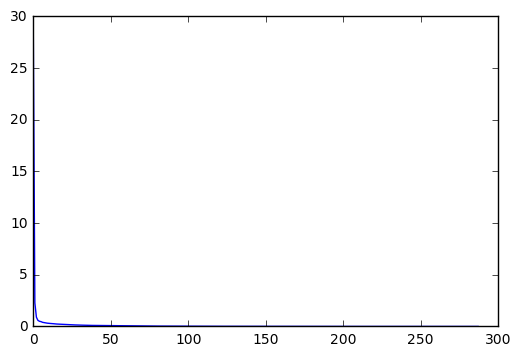

In [46]:
plot(s)

Plot of Variance Explained

In [47]:
sum = []
sumSoFar = 0
for k in range (len(s)):
    sumSoFar = sumSoFar + s[k]
    sum.append(sumSoFar)

In [48]:
varExplained = sum/sum[len(s)-1]

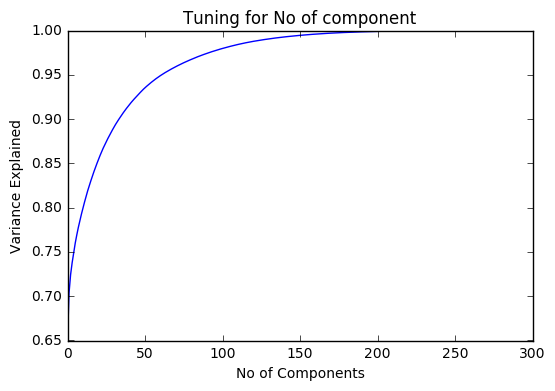

In [49]:
plot(varExplained)
plt.xlabel("No of Components")
plt.ylabel("Variance Explained")
plt.title("Tuning for No of component")

In [50]:
varExplained[100]

0.97974314540453589

First 200 components explains 97% of the variance, we will keep them

In [51]:
V.shape

(288, 288)

In [52]:
U.shape

(288, 288)

In [53]:
X_train_normalized.shape

(1460, 288)

In [54]:
Ureduced = U[:, 0:100]

In [55]:
a = [3, 4]

In [56]:
np.linalg.norm(Ureduced[:,2])

0.99999999999999956

Every column of U is a unit vector 

In [57]:
Ureduced.shape

(288, 100)

In [58]:
Z_train = X_train_normalized.dot(Ureduced)

In [59]:
Z_train.shape

(1460, 100)

In [60]:
def my_cv_matrix_reduced(xin, yin, n_splits, features):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_train)
    ary = []
    for train_index, test_index in kf.split(xin):       
        Xtr, Xte = xin[train_index], xin[test_index]
        Ytr, Yte = yin[train_index], yin[test_index]
        ans = get_accuracy_matrix_reduced(Xtr, Xte, Ytr, Yte, features)
        ary.append(ans)
    return np.mean(ary)


def get_accuracy_matrix_reduced(Xtr, Xte, Ytr, Yte, features):
    Ureduced = U[:, 0:features] 
    #process xtr
    Xtr = Xtr.dot(Ureduced)
    i = [1 for j in range(Xtr.shape[0])]
    i = np.array(i)
    i = np.expand_dims(i, axis=1)
    Xtr = np.hstack((i, Xtr)) 
    
    #process xte
    Xte = Xte.dot(Ureduced)
    i = [1 for j in range(Xte.shape[0])]
    i = np.array(i)
    i = np.expand_dims(i, axis=1)
    Xte = np.hstack((i, Xte)) 
    
    temp0 = Xtr.T.dot(Xtr)
    temp1 = linalg.inv(temp0)
    parameter = temp1.dot(Xtr.T).dot(Ytr)
    
    Ypred = Xte.dot(parameter)
    return direct_rmse_error(Yte, Ypred)

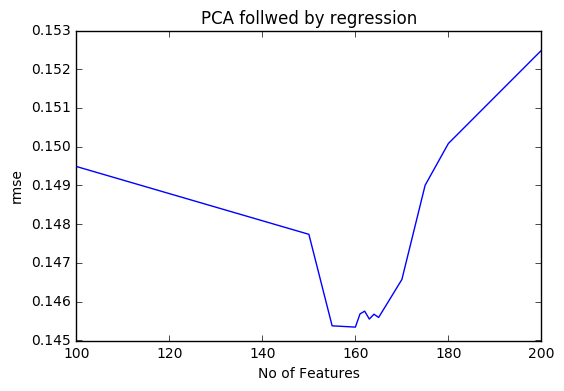

In [61]:
features = [100, 150, 155, 160, 161, 162, 163, 164, 165, 170, 175, 180, 200]
cv_ridge = []
cv_ridge = [my_cv_matrix_reduced(X_train_normalized, y, 5, f) 
            for f in features]
cv_ridge = pd.Series(cv_ridge, index = features)
cv_ridge.plot(title = "PCA follwed by regression")
plt.xlabel("No of Features")
plt.ylabel("rmse")

In [65]:
my_cv_matrix_reduced(X_train_normalized, y, 5, 100) 

0.14949040654794749

In [62]:
def get_accuracy_lstsq_reduced(Xtr, Xte, Ytr, Yte, features):
    Ureduced = U[:, 0:features] 
    #process xtr
    Xtr = Xtr.dot(Ureduced)
    i = [1 for j in range(Xtr.shape[0])]
    i = np.array(i)
    i = np.expand_dims(i, axis=1)
    Xtr = np.hstack((i, Xtr)) 
    
    #process xte
    Xte = Xte.dot(Ureduced)
    i = [1 for j in range(Xte.shape[0])]
    i = np.array(i)
    i = np.expand_dims(i, axis=1)
    Xte = np.hstack((i, Xte)) 
    
    theta, residual, rank, singular = linalg.lstsq(Xtr, Ytr)
    Ypred = (Xte).dot(theta)
    return direct_rmse_error(Yte, Ypred)

In [63]:
def my_cv_matrix_reduced_lst(xin, yin, n_splits, features):
    kf = KFold(n_splits=n_splits)
    kf.get_n_splits(X_train)
    ary = []
    for train_index, test_index in kf.split(xin):       
        Xtr, Xte = xin[train_index], xin[test_index]
        Ytr, Yte = yin[train_index], yin[test_index]
        ans = get_accuracy_lstsq_reduced(Xtr, Xte, Ytr, Yte, features)
        ary.append(ans)
    return np.mean(ary)

In [64]:
my_cv_matrix_reduced_lst(X_train_normalized, y, 5, 100) 

0.14949040654785006